# Regression Techniques
-----------------------------------------------------------------------------------------------------------------------------
*This is the second part of the Thesis Project. In the [first part](https://github.com/nikosga/Thesis/blob/master/Part%201__Data%20Cleaning.ipynb) two datasets were created. The first one is going to be used here and the following regression techniques are going to be tested w.r.t the predictive power and interpretability they offer. Before getting our hands dirty some brief introduction.*

## *Linear Regression*

* One of the best techniques in terms of interpretability. It assumes an affine relationship between the dependent variable and the parameters. We can also include nonlinear transformations of the already included features. 
* It's fully characterized by a set of parameters and the main task is to compute the parameter values that minimize some loss function, usually the sum of squared residuals.
* The linear assumption is often a luxury and as we will see, it's performance in high dimensional data (large number of features relative to sample size) is terrible given the strong multicollinearity issues.
* The betas can be computed either analytically or using some optimization algorithm like Gradient Descent [(explanation by Andrew Ng)](https://www.coursera.org/learn/machine-learning/lecture/GFFPB/gradient-descent-intuition) usually prefered when the matrix to be inversed has over 10K elements.

## *Ridge & Lasso*
* Similar to the Linear Regression framework in the sense that we have to compute the beta parameters that minimize some loss function.
* The difference is that they perform [Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics). These techniques penalize the coefficients using a parameter lamda multiplied by the L1 or L2 norms of the betas in order to avoid overfitting.
* Ridge penalizes the betas but keeps them in the model, while Lasso performs subset selection too.
* If the dataset is characterized by high multicollinearity usually Lasso performs better. Otherwise Ridge should be prefered.
* They still keep the linear character but interpreting a model with over 50 features has it's issues. 
* Ridge coefficients can be computed either analytically or using Gradient Descent-type algorithms. On the other hand the Lasso coefficients cannot be computed analytically and since the loss function is not smooth at the minimum a different version of Gradient Descent is used called [Coordinate Descent](https://en.wikipedia.org/wiki/Coordinate_descent). 

## *Principal Component Regression*
* It's actually a combination of Principal Component Analysis and Linear Regression. The first technique is used for dimension reduction (choosing the eigenvectors that explain the largest amount of variance) and then Linear Regression is performed on the selected principal components.
* Since it decreases the number of features, Linear Regression that is performed afterwards, overcomes the high variance problem.
* On the other hand the principal components are a linear combinations of the initial features and not real variables, so we lose in interpretability.
* There is another algorithms that performs a similar task called [Partial Least Squares](https://en.wikipedia.org/wiki/Partial_least_squares_regression).

## *Gradient Boosting*
* While the techniques described above are parametric, Gradient Boosting is a non-parametric machine learning technique.
* It can be used for both regression and classification tasks. It produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
* The methodology is similar to that of Genaralized Additive Models. The difference is that Boosting follows a *stagewise fitting* procedure. That means that one parameter is optimised while the others remain fixed and as a result overfitting is reduced.
* Constraining the fitting procedure by choosing the number of iterations or the size of the decision trees can deal with the high variance problem.
* It's is not as strong in interpretability as parametric techniques are, but the algorithm measures the feature importance while fitting and thus can be used as a feature selection tool. We can also produce some partial dependency plots to depict the *ceteris paribus* relationship between some feature and the dependent variable.

*We can now move to testing.*

In [1]:
#importing modules
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.metrics import r2_score,mean_squared_error
#importing data
df = pd.read_csv("C:\\Users\\nikos\\Desktop\\thesisdata\\new2014.csv",index_col=0)
df.head(4)

,Life Ladder,"Adolescent fertility rate (births per 1,000 women ages 15-19)",Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Average precipitation in depth (mm per year),Cost of business start-up procedures (% of GNI per capita),Cost to export (US$ per container),Cost to import (US$ per container),DEC alternative conversion factor (LCU per US$),...,"Tuberculosis case detection rate (%, all forms)","Unemployment, female (% of female labor force)","Unemployment, male (% of male labor force)","Unemployment, total (% of total labor force)","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)",Urban population,Urban population (% of total),Urban population growth (annual %)
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,3.130896,76.7336,89.773777,4.620393,85.153384,327.0,15.1,5045.0,5680.0,57.4311,...,53.0,14.000000,8.2,9.1,28.100000,19.299999,20.799999,8312341.0,26.282,4.609630
Algeria,6.354898,10.7914,51.536631,8.794346,42.742285,89.0,11.0,1270.0,1330.0,80.5790,...,74.0,16.799999,8.0,9.5,32.000000,17.600000,20.000000,27304259.0,70.129,2.826978
Armenia,4.453083,23.5084,41.329330,14.952075,26.377256,562.0,1.0,1885.0,2175.0,415.9198,...,98.0,18.799999,15.8,17.1,41.700001,31.299999,35.099998,1888225.0,62.812,0.206332
Australia,7.288550,14.4050,50.231115,22.120440,28.110675,534.0,0.7,1200.0,1220.0,1.0893,...,88.0,5.900000,6.0,6.0,12.200000,14.000000,13.100000,20974643.0,89.289,1.717861


In [2]:
print("Dataset shape : \n\t"+str(df.shape[0])+" samples\n\t"+str(df.shape[1])+" features")

Dataset shape : 
	103 samples
	138 features


Observe that the number of samples is smaller than that of features.
 Separating features from dependent variable :

In [3]:
y = df.iloc[:,0]
X = df.drop(["Life Ladder"],axis=1)

A useful indicator of overfitting is the difference between the R^2 computed from fitting the model in the entire dataset versus the one computed after splitting the set in testing and training subsets. For example in the case of Linear Regression the two measurements would be :

In [4]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=2)
linreg = LinearRegression(normalize=True)
print("r2 before split : "+str(r2_score(y,linreg.fit(X,y).predict(X)))+
     "\nr2 after split : "+str(r2_score(ytest,linreg.fit(Xtrain,ytrain).predict(Xtest))))

r2 before split : 1.0
r2 after split : -9.01241769905


and even if the fit after the split was not that terrible ( R^2 < 0  means that a horizontal line explains the data better than the model [see here](https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean)) the fact that the model hits 100% accuracy before split is a clear sign of high variance. So Linear Regression is pretty useless here. As mentioned earlier Ridge and Lasso overcome this obstacle with coefficient penalization.  Before moving to the comparison of these two models let's see first what penalization actually does to the coefficients.

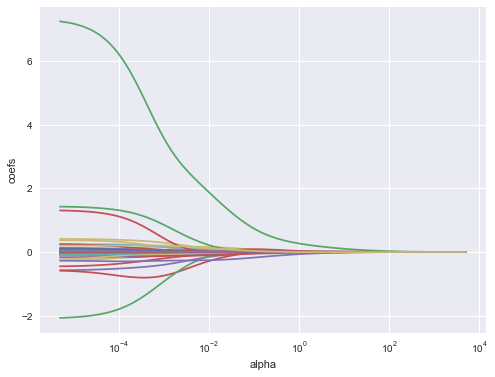

In [5]:
#tunning parameter alpha
alphas = 10**np.linspace(4,-5,100)*0.5
ridge = Ridge(normalize = True)
coefs = []
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefs')

As the alpha increases the betas converge to zero. Let's see what happens in the Lasso case

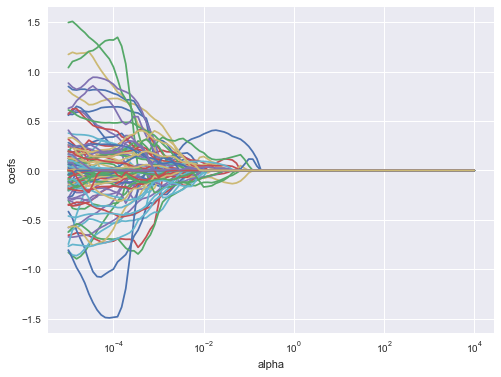

In [6]:
import warnings
warnings.filterwarnings('ignore')
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(Xtrain), ytrain)
    coefs.append(lasso.coef_)
plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefs')

There are some differences between the two plots. The first one is that ridge converges to zero smoothly. The second is that in the Lasso case the coefficients actually hit zero while in the ridge case they don't . It has to do with the metrics used for regularization. An intuitive explanation can be found [here](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization-How-does-it-solve-the-problem-of-overfitting-Which-regularizer-to-use-and-when/answer/Justin-Solomon)

![](http://c431376.r76.cf2.rackcdn.com/36264/fpsyg-04-00161-HTML/image_m/fpsyg-04-00161-g003.jpg)

Before moving to prediction we should also choose the tuning parameter. If we used alpha = 0 in both models we would move back to the Linear Regression case since no penalization would occur. As alpha increases the solutions diverge. We can use cross validation to choose the ideal alpha for each case and then make our prediction. In the next plot we can see how the R^2 value changes w.r.t alpha for the Ridge case

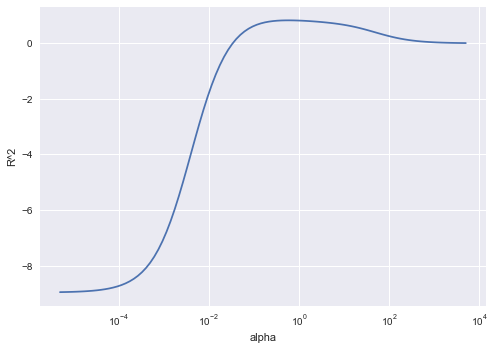

In [7]:
ridge = Ridge(normalize = True)
Rsq = []
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(Xtrain, ytrain)
    Rsq.append(r2_score(ytest, ridge.predict(Xtest)))
ax = plt.gca()
ax.plot(alphas, Rsq)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('R^2')

Observe that as alpha goes to zero, R^2 goes to the value it had in the Linear Regression case while as we increase alpha the penalization can make the coefficients so small that would be equivalent to regressing y on a vector of ones. The R^2 becomes zero.

In [8]:
#find optimal alpha for Ridge
ridgecv = RidgeCV(alphas = alphas, scoring = 'mean_squared_error', normalize = True)
ridgecv.fit(Xtrain, ytrain)
#find optimal alpha for Lasso
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(Xtrain, ytrain)
print("optimal alpha for Ridge : "+str(ridgecv.alpha_))
print("optimal alpha for Lasso : "+str(lassocv.alpha_))

optimal alpha for Ridge : 2.16438064054
optimal alpha for Lasso : 0.010728597104


Using the optimal alphas we can now compare the prediction accuracy

In [9]:
ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge.fit(Xtrain, ytrain)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(Xtrain, ytrain)
print("Ridge: "+ str(r2_score(ytest, ridge.predict(Xtest))))
print("Lasso: "+ str(r2_score(ytest, lasso.predict(Xtest))))

Ridge: 0.773703480447
Lasso: 0.732800927308


Ridge does a very good job but Lasso has performed feature selection, so there is a trade off in choosing one over the other. The coefficients that survived in the Lasso case are: 

In [10]:
coef = pd.Series(lasso.coef_, index=X.columns)
print(coef[coef!=0])

Average precipitation in depth (mm per year)                                                                    0.000023
Employment to population ratio, ages 15-24, male (%) (modeled ILO estimate)                                     0.002055
GDP per capita (current US$)                                                                                    0.000004
GDP per capita, PPP (constant 2011 international $)                                                             0.000003
Improved sanitation facilities, urban (% of urban population with access)                                       0.017542
Merchandise exports to high-income economies (% of total merchandise exports)                                   0.002088
Merchandise imports from developing economies in Middle East & North Africa (% of total merchandise imports)   -0.015379
Mortality rate, under-5 (per 1,000)                                                                            -0.003324
Price level ratio of PPP convers

We cannot speak about causality. The secret ingredient to making citizens happy is not found, but these are the feautures than are more linearly related to happiness than the others used to construct the model. Other features could have also make it to the last round. It's just that Lasso chooses one feature among those that are highly correlated. The feature selection seems intuitive. We can see that unemployment, gdp, business and exports, education and health are strong predictors of happiness. Quite unexpected is the fact that rainfall (average precipitation) and the number of women holding seats in national parliaments play such a role and the former in a counter-intuitive way. Many of these features are also correlated. For example a country with high gdp levels usually spends more money in education and health. These are interesting results but let's continue the analysis with the PCR algorithm.

First step: Compute the principal components of the covariance matrix between the features.

In [17]:
pca = PCA()
# Computing principal components
Xreducedtrain = pca.fit_transform(scale(Xtrain))
print("The first 4 rows for the first 5 components : ")
pd.DataFrame(pca.components_.T).loc[:4,:4] 

The first 4 rows for the first 5 components : 


,0,1,2,3,4
0,0.147421,-0.006339,-0.032638,-0.047980,-0.041524
1,0.134380,-0.010438,-0.029860,-0.136950,-0.093660
2,-0.138745,0.004818,-0.064631,-0.100013,0.048075
3,0.161388,-0.010054,0.003890,-0.063947,-0.092235
4,0.027507,0.018715,-0.065542,0.090548,0.101800


Second Step: Choose the number of principal componets that will be used performing cross validation 

In [18]:
n = len(Xreducedtrain)
CV = KFold( n_splits=10, shuffle=True, random_state=1)
mse = []
linreg = LinearRegression()
# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(linreg, np.ones((n,1)), ytrain.ravel(), cv=CV, scoring='neg_mean_squared_error').mean()
mse.append(score)
# Calculate MSE using CV for the 20 principle components, adding one component at the time.
for i in np.arange(1, 21):
    score = -1*cross_val_score(linreg, Xreducedtrain[:,:i], ytrain.ravel(), cv=CV, scoring='neg_mean_squared_error').mean()
    mse.append(score)

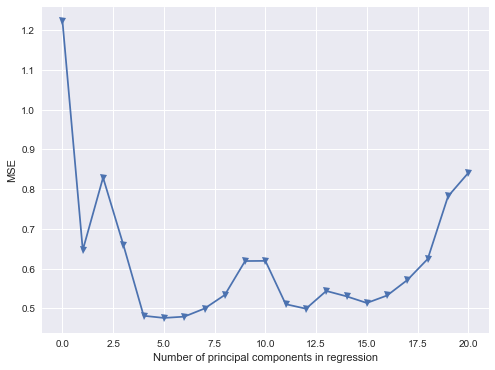

In [19]:
plt.figure(figsize=(8,6))
plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.xlim(xmin=-1);

Third Step: Perform Linear Regression using the first 5 components

In [20]:
Xreducedtest = pca.transform(scale(Xtest))[:,:5]
# Train regression model on training data
linreg = LinearRegression()
linreg.fit(Xreducedtrain[:,:5], ytrain)
# Prediction with test data
pred = linreg.predict(Xreducedtest)
print("PCA : "+str(r2_score(ytest, pred)))

PCA : 0.695595174338


In Python there is no direct way to implement PCR so we had to break the procedure in steps. PCA is a method used for dimension reduction. The construction of principal components is based only on the features and not on the predictive power they have over the dependent variable and that usually drops the accuracy score. The final algorithm to be tested is Gradient Boosting. More information on the parameters can be found in the sklearn [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).

In [21]:
#GradientBoostingRegressor
params = {'n_estimators': 700, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls','max_features' :7,'random_state':0}
clf = GradientBoostingRegressor(**params)
clf.fit(Xtrain, ytrain)
print("Gradient Boosting : "+str(r2_score(ytest, clf.predict(Xtest))))

Gradient Boosting : 0.845342379465


Checking if the algorithm has converged...

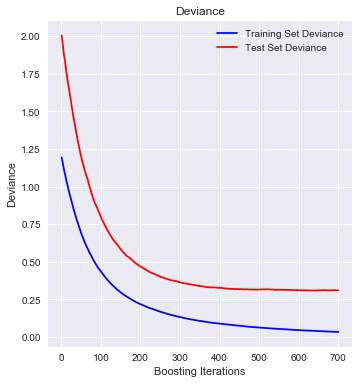

In [24]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)    
for i, y_pred in enumerate(clf.staged_predict(Xtest)):
    test_score[i] = clf.loss_(ytest, y_pred)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

As mentioned earlier like Lasso, Gradient Boosting performs feature selection. The most important features are:

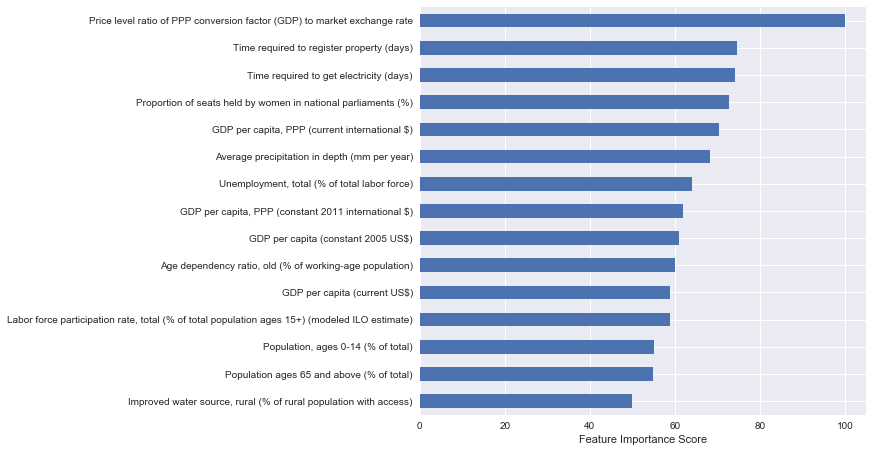

In [22]:
feat_imp1 = pd.Series(100*clf.feature_importances_/clf.feature_importances_.max(),index=Xtrain.columns).sort_values(ascending=True)
feat_imp1[feat_imp1>50].plot(kind='barh',figsize=(8,7.5));plt.xlabel('Feature Importance Score')

Gradient Boosting has kept all the gdp terms even though they are highly correlated between them, while Lasso did a better job. On the other hand the prediction power is so much better than that of all the previously tested algorithms. We can also see how these features relate to the dependent variable. 

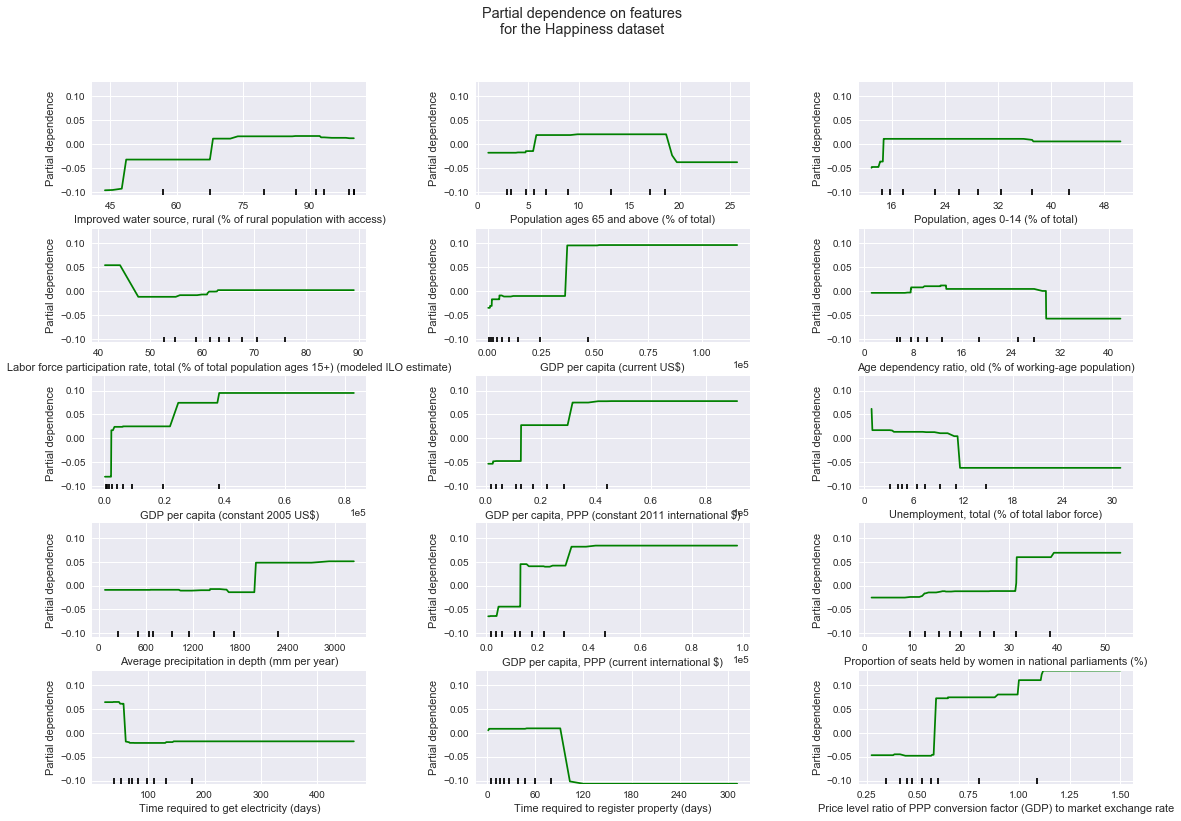

In [23]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
feat = list(feat_imp1[feat_imp1>50].index)
features = column_index(Xtrain,feat)
names = Xtrain.columns
fig, axs = plot_partial_dependence(clf, Xtrain, features,figsize=(17,13),
                                   n_jobs=2,feature_names=names)
fig.suptitle('Partial dependence on features\n'
             'for the Happiness dataset')
plt.subplots_adjust(top=0.9)

Even if we don't have coefficients so that we can understand the relationship between the features and the dependent variable we can use partial dependency plots. Gradient Boosting also offers features selection so I would say that this Machine Learning algorithm is by far the winner.